<a href="https://colab.research.google.com/github/geunsu-jo/Hands-On-ML/blob/main/textbook_practice/04_training_linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 선형 모델 훈련

선형 회귀 모델을 훈련하는 방법에는 크게 2가지가 있다.
- 직접 계산할 수 있는 공식을 사용해 훈련세트에 가장 잘맞는 모델을 __해석적__으로 구한다.
- __경사하강법(GD)__으로 모델 파라미터를 수정하여 훈련세트의 비용함수를 최소하하여 구한다.

## 선형 회귀

앞 장에서, RMSE(Root MSE)를 최소하하는 $\theta$를 찾았지만, MSE를 최소화 하는 $\theta$를 찾는 방법과 같다. <br>
실제로 비용함수(Cost function)로 MSE를 사용해야 미분 특성상 계산이 단순하고, 규제(Regularization)적용이 가능하다.


### 정규 방정식

normal equation이라고 불리고, 식은 다음과 같다. <br>
$\hat{\theta} = (X^{t}X)^{-1}X^{t}y$ 

데이터를 무작위로 추출하여 정규방정식으로 계산 결과를 살펴보자

In [ ]:
# 데이터 생성
import numpy as np
X = 2* np.random.rand(100, 1) # 임의의 x를 추출하여
y = 4 + 3 * X + np.random.randn(100, 1) # noise 추가

In [ ]:
# summing vector 추가
X_b = np.c_[np.ones((100, 1)), X]
# theta 계산
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.08602319],
       [3.03030591]])

임의의 새로운 데이터 $x_{0}=(0,2)^{t}$에 대한 $\hat{y}_{0}$ 계산

In [ ]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.08602319],
       [10.14663501]])

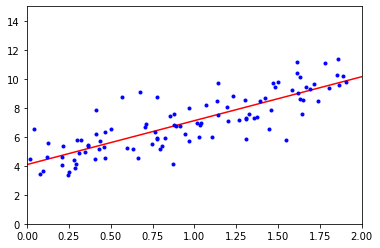

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

사이킷런에서 선형 회귀

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lin_reg.intercept_, lin_reg.coef_, lin_reg.predict(X_new)

(array([4.08602319]), array([[3.03030591]]), array([[ 4.08602319],
        [10.14663501]]))

- 사이킷런을 사용하지 않은 결과와 완전히 동일

특성(feature)의 수가 샘플보다 많거나 Linear dependent여서 $(X^{t}X)^{-1}$를 구할 수 없는 경우, __일반화 역행렬(Generalized inverse)__을 이용한다. <br>
특히, 특이값 분해(Singular Value Decomposition)으로부터 나온 __Moor-Penrose Inverse__($X^{+}$)을 이용한다. <br>
$\hat{\theta} = X^{+}y$

In [ ]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.08602319],
       [3.03030591]])

- SVD로부터 $X=UDT^{t}$를 구한 후, D의 diagonal component가 rcond보다 작으면 0으로 바꾼 다음,  $X^{t}=TD^{+}U^{t}$를 구한다

numpy의 __np.linalg.pinv()__ 함수를 사용해도 Moor-Penrose inverse를 구할 수 있다.

In [ ]:
np.linalg.pinv(X_b).dot(y)

array([[4.08602319],
       [3.03030591]])

### 계산 복잡도

$n$을 특성(feature)의 수라 할때, $X^{t}X$의 역행렬 크기는 $(n+1)*(n+1)$이고, 정규방정식의 __계산 복잡도__(Computational complexity)는 일반적으로 $O(n^{2.4})$에서 $O(n^{3})$ 사이다. 즉, 특성의 수가 2배로 늘어나면 약 5.3~8배로 증가한다. <br>하지만 사이킷런의 __LinearRegression__ 클래스가 사용하는 SVD 방법은 계산 복잡도가 $O(n^{2})$이다. 특성의 수가 2배로 늘어나면 계산 시간은 4배가 된다. <br>
$m$을 샘플의 수라 할때, 정규방정식과 SVD 모두 $O(m)$으로, 샘플이 두배가 되면 계산 시간도 선형적으로 2배가 된다.

## 경사 하강법

해석적으로 최적의 해법을 찾을 수 없을 경우, 일반적인 최적의 해를 찾는 알고리즘이다. <br>
$\theta$을 __무작위 초기화__(random initialization)시켜 비용함수(MSE 등)을 감소하는 방향으로 $\theta$를 업데이트 시킨다. <br>
__학습률__(learning rate)은 하이퍼파라미터로 적절이 튜닝되야한다.

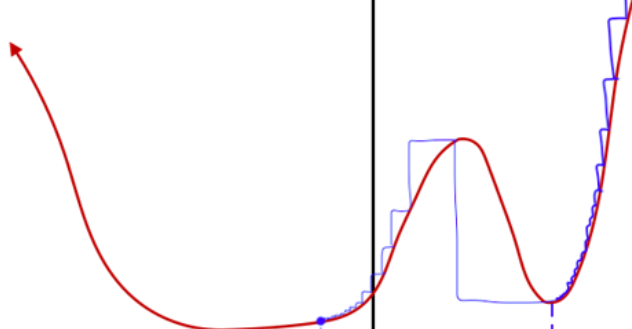